# Spherinator Training using Illustris TNG

This notebook demonstrates how to train a Spherinator model using the Illustris TNG dataset.

## Download data

Please put your [Illustris API key](https://www.tng-project.org/data/access/) to the `.illustris_api_key.txt` file.

In [11]:
import os

with open(".illustris_api_key.txt", "r") as file:
    ILLUSTRIS_API_KEY = file.read().rstrip()

with open("subhalo_ids.txt", "r") as file:
    subhalo_ids = [int(line.strip()) for line in file.readlines()]

for sid in subhalo_ids:
    if os.path.exists(f"./data/illustris/fits/TNG100/sdss/snapnum_099/data/broadband_{sid}.fits"):
        continue
    !wget -nc -P ./data/illustris/fits/TNG100/sdss/snapnum_099/data --content-disposition\
        --header="API-Key: {ILLUSTRIS_API_KEY}"\
        "http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/{sid}/skirt/broadband_sdss.fits"

## Data preparation

We use PEST to transform the FITS files to a parquet format. 

In [12]:
from pest import FitsConverter

FitsConverter(image_size=128).convert_all(
    "data/illustris/fits/TNG100/sdss/snapnum_099/data", "data/illustris/parquet"
)

In the parquet schema the metadata `simulation`, `snapshot`, and `subhalo_id` are stored in the
`metadata` column. The `data` column contains the actual data as a list. The actual shape `(3, 128,
128)` is stored in the schema metadata.

In [17]:
import pyarrow.dataset as ds

dataset = ds.dataset("data/illustris/parquet", format="parquet")
dataset.schema

data: list<element: double>
  child 0, element: double
simulation: string
snapshot: string
subhalo_id: string
-- schema metadata --
data_shape: '(3, 128, 128)'

## Visualize training data

To get an impression of the data, we can visualize the first 50 images of the training data.

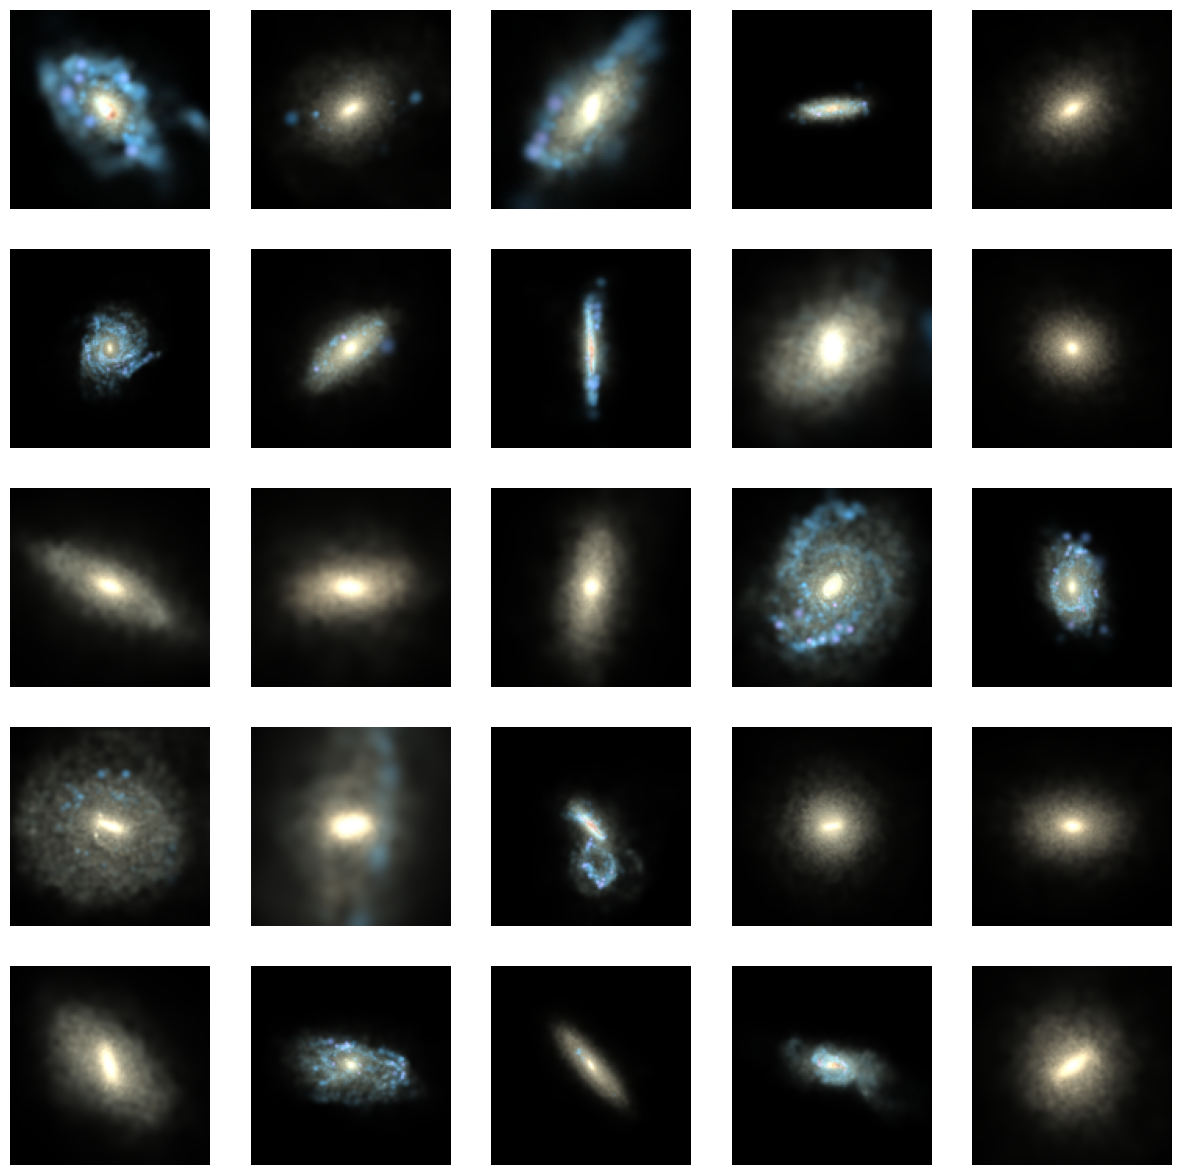

In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

df = dataset.to_table().to_pandas()
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    data = np.array(df["data"][i]).reshape(3, 128, 128).transpose(1, 2, 0) * 255
    image = Image.fromarray(data.astype(np.uint8), "RGB")
    ax.imshow(image)
    ax.axis("off")
plt.show()

## Training the model

As model we define a `VariationalAutoencoder` with a convolutional network as encoder and decoder.

In [25]:
import spherinator.models as sm

model = sm.VariationalAutoencoder(
    encoder=sm.ConvolutionalEncoder2D(
        input_dim=[3, 128, 128],
        output_dim=128,
        cnn_layers=[
            sm.ConsecutiveConv2DLayer(
                kernel_size=3,
                stride=1,
                padding=0,
                out_channels=[16, 20, 24],
            ),
            sm.ConsecutiveConv2DLayer(
                kernel_size=4,
                stride=2,
                padding=0,
                out_channels=[64, 128],
            ),
        ],
    ),
    decoder=sm.ConvolutionalDecoder2D(
        input_dim=3,
        output_dim=[3, 128, 128],
        cnn_input_dim=[128, 28, 28],
        cnn_layers=[
            sm.ConsecutiveConvTranspose2DLayer(
                kernel_size=5,
                stride=2,
                padding=0,
                out_channels=[64],
            ),
            sm.ConsecutiveConvTranspose2DLayer(
                kernel_size=6,
                stride=2,
                padding=0,
                out_channels=[24],
            ),
            sm.ConsecutiveConvTranspose2DLayer(
                kernel_size=3,
                stride=1,
                padding=0,
                out_channels=[20, 16, 3],
                activation=None,
            ),
        ],
    ),
    z_dim=3,
    beta=1.0e-4,
    encoder_out_dim=128,
)

## ParquetDataModule

In [23]:
from spherinator.data import ParquetDataModule

datamodule = ParquetDataModule(
    data_directory="data/illustris/parquet",
    data_column="data",
    normalize="minmax",
    batch_size=256,
    num_workers=4,
    shuffle=True,
)

In [26]:
from lightning.pytorch import Trainer

trainer = Trainer(
    max_epochs=10,
    accelerator="gpu",
    precision="16-mixed",
)
trainer.fit(model, datamodule=datamodule)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 500 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                   | Params | Mode  | In sizes         | Out sizes       
-------------------------------------------------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2D | 13.9 M | train | [

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Visualize the reconstructed images

## Export the trained model to ONNX

- The model include the variational autoencoder part, which is not needed for the Inference.
- We export only the encoder and the decoder part of the model.
- Dynamic axes are used to allow for variable input sizes.
- Unique names are used for the input and output tensors.

In [12]:
import torch

onnx = torch.onnx.export(
    model.variational_encoder,
    torch.randn(2, 3, 128, 128, device="cpu"),
    dynamic_axes={"x": {0: "batch"}},
    input_names=["x"],
    output_names=["coord", "scale"],
    dynamo=True,
)
onnx.optimize()
onnx.save("data/illustris/models/encoder.onnx")

onnx = torch.onnx.export(
    model.decoder,
    torch.randn(2, 3, device="cpu"),
    dynamic_axes={"input": {0: "batch"}},
    dynamo=True,
)
onnx.optimize()
onnx.save("data/illustris/models/decoder.onnx")

[torch.onnx] Obtain model graph for `VariationalEncoder([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `VariationalEncoder([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


W0424 12:53:05.605000 1843850 torch/fx/experimental/symbolic_shapes.py:6184] Ignored guard s0 >= 16 == False, this could result in accuracy problems


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.


/home/doserbd/git/SPACE_HPC_Visualization_Workshop/.venv/lib/python3.12/site-packages/torch/onnx/_internal/exporter/_compat.py:262: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  warnings.warn(


[torch.onnx] Obtain model graph for `ConvolutionalDecoder2D([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ConvolutionalDecoder2D([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


W0424 12:53:06.594000 1843850 torch/fx/experimental/symbolic_shapes.py:6184] Ignored guard s0 >= 16 == False, this could result in accuracy problems


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.


## Visualize the ONNX model with netron 

In [13]:
!pip install -q netron
import netron
netron.start('data/illustris/models/encoder.onnx', 8081)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Stopping http://localhost:8081
Serving 'data/illustris/models/encoder.onnx' at http://localhost:8081


('localhost', 8081)

## Pytorch Lightning Commnd Line Interface (CLI)

Start the training using a unique [yaml config-file](./configs/spherinator/illustris.yaml) in reproducible mode.

In [ ]:
!spherinator fit --c configs/spherinator/illustris.yaml